In [76]:
# 라이브러리 불러오기 + 데이터불러오기 + 데이터 테이블화 하기 및 확인하기 
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error


train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
#데이터 잘 불러와졌는지 확인하기 
print(train)
print(test)



        id  hour  hour_bef_temperature  hour_bef_precipitation  \
0        3    20                  16.3                     1.0   
1        6    13                  20.1                     0.0   
2        7     6                  13.9                     0.0   
3        8    23                   8.1                     0.0   
4        9    18                  29.5                     0.0   
...    ...   ...                   ...                     ...   
1454  2174     4                  16.8                     0.0   
1455  2175     3                  10.8                     0.0   
1456  2176     5                  18.3                     0.0   
1457  2178    21                  20.7                     0.0   
1458  2179    17                  21.1                     0.0   

      hour_bef_windspeed  hour_bef_humidity  hour_bef_visibility  \
0                    1.5               89.0                576.0   
1                    1.4               48.0                916.0   
2  

In [4]:
#train 데이터만 보자(test는 검증할 때 필요...)
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [25]:
train.tail()
#target 값 : count임을 확인 가능 
train.shape
#데이터 개수 : 1459개, feature개수 : 11개임을 확인이 가능하다. 

(1459, 11)

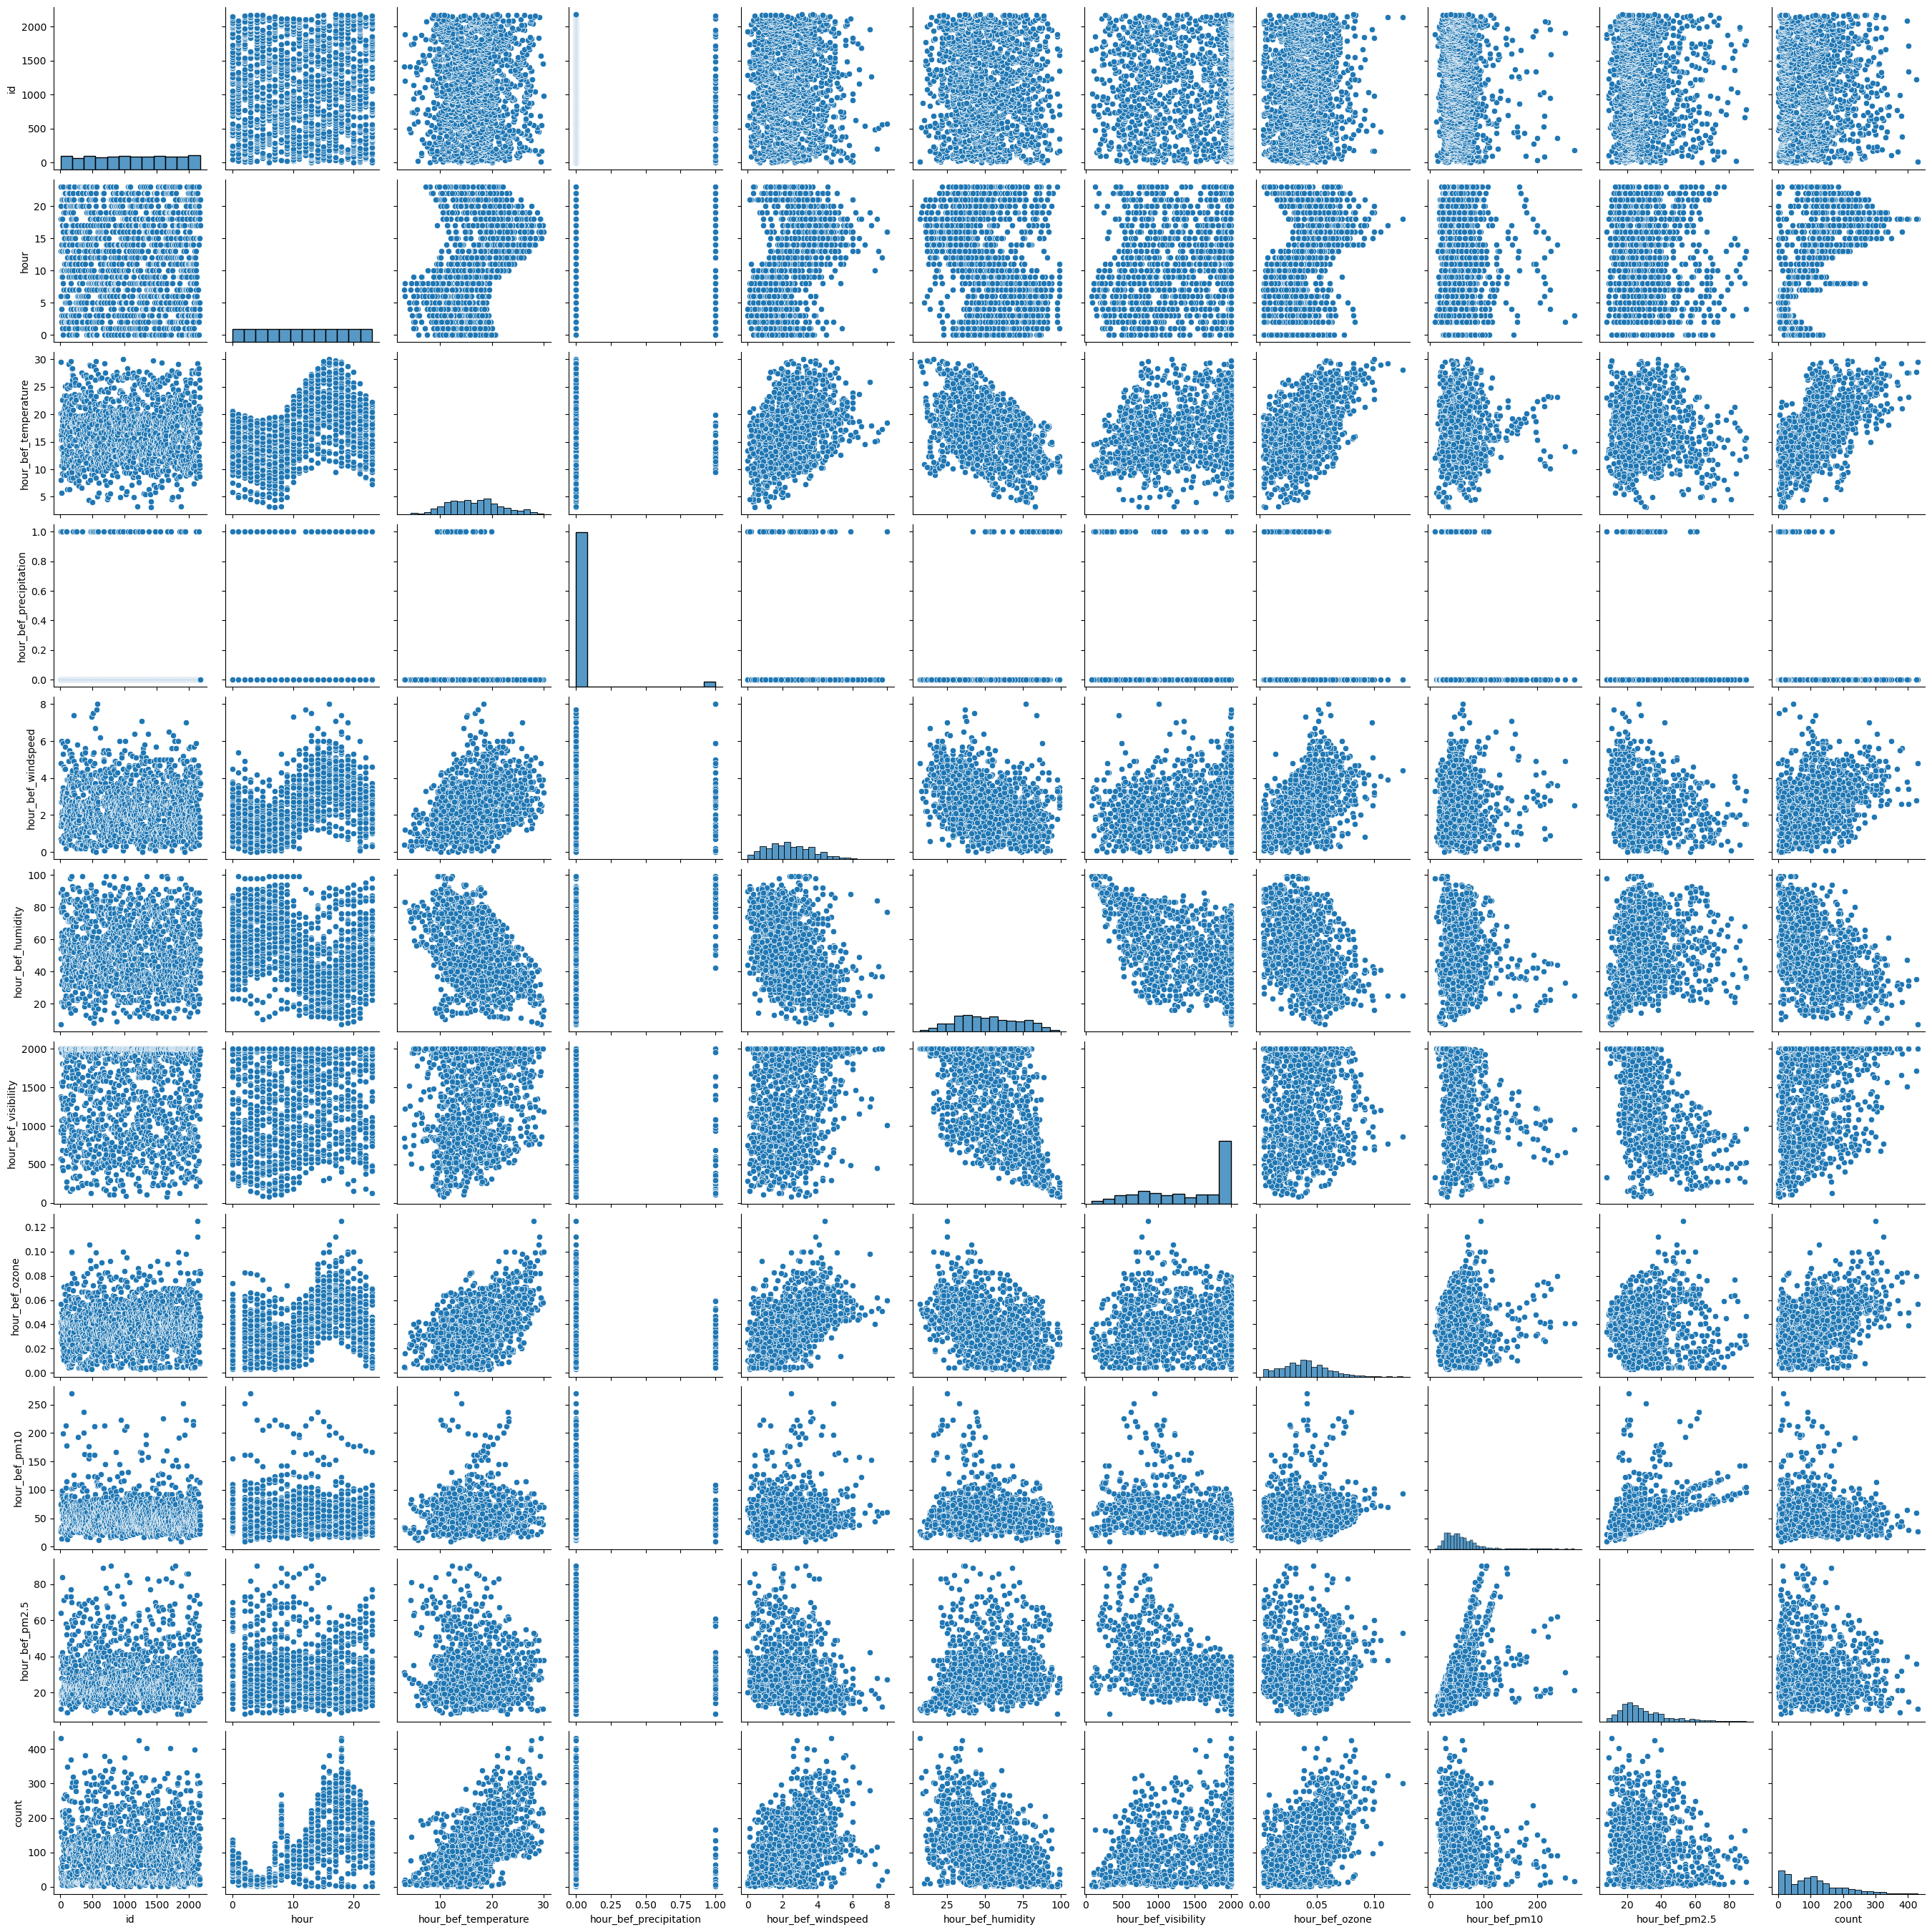

In [6]:
# 데이터 프레임 그리려고 했으나, 위에서 이미 표형식으로 잘 나와 있어서 에러가 뜬다. 그냥 바로 pairplot이랑 histplot으로 개괄적으로 
# 데이터들이 어떻게 생겼는지 보면 될 것 같음 

#pairplot으로 feature간 관계성 보기 

sns.pairplot(train)

In [34]:
#count가 target 값이므로 다른 feature-count만 떼서 만든 pairplot 그려서 살펴보기 
#hour-count
sns.pairplot(train.loc[:, ['hour','count']])

In [35]:
#hour- temperature
sns.pairplot(train.loc[:, [ 'hour_bef_temperature', 'count']])

In [42]:
sns.pairplot(train.loc[:, ['hour','hour_bef_precipitation', 'hour_bef_windspeed', 'hour_bef_humidity','count' ]])


In [44]:
#bef_pm과 count 관계도 (비슷한 것들끼리 묶어줘서 확인했음)
sns.pairplot(train.loc[:, ['hour','hour_bef_precipitation', 'hour_bef_windspeed', 'hour_bef_humidity','count' ]])


In [28]:
# test 테이블 확인하기
test.head()
test.tail()
#test 데이터셋 개수는 714개고 count(target) 이 비어있음 -> 모델의 성능 확인 제한적 -> test ^y값을 비교하는 것이 불가능하므로 k-fold 쓰는 게 좋다고 지난 시간에 얘기가 나왔다.


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
710,2148,1,24.6,0.0,2.4,60.0,1745.0,NaN,NaN,NaN
711,2149,1,18.1,0.0,1.0,55.0,2000.0,NaN,NaN,NaN
712,2165,9,23.3,0.0,2.3,66.0,1789.0,0.020,17.0,15.0
713,2166,16,27.0,0.0,1.6,46.0,1956.0,0.032,40.0,26.0
714,2177,8,22.3,0.0,1.0,63.0,1277.0,0.007,30.0,24.0


In [49]:
# histplot 그려서 확인하기 (target 속성외의 값들-target속성과의 선형적 관계 확인 + 정규분포도로 그리기)

#histplot그리기 : sns.histplot(데이터셋 이름, x=feature이름들(x=이면 세로형, y=이면 가로형), bins = ,hue='두개 이상을 겹쳐 그릴 떄 그것을 포괄하는 카테고리 이름', bins='probability' #모든 막대의 합은 1이다.  'col' 파라미터를 사용해서 각각의 그래프로 쉽게 나누어서 나타낼 수 있다.)
# 그런데 일일이 위처럼 하나하나 속성 loc으로 하면...한꺼번에 출력이되어버리니 자동으로 하나하나 넣고 싶음 -> for 문에서 가져오자 
# 속성들을 컬럼으로 지정하면 되지 않을까?
#컬럼을 인덱스화시켜서 꺼내서 자동으로 plot그리게 만들기 

columns = ['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity',
          'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count']

for col in columns :
    sns.histplot(train, x=col, bins=100,  element='step', stat='probability')
    

In [50]:
#결측치 확인하기 
#칼럼별 결측값 구하기 
train.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

## 결측치 채우는 방법(결측치 처리방법)

#### 1. 행 또는 열 삭제 : 결측치가 존재하는 행 또는 열을 삭제하는 것

#### 2. 중앙값, 평균값으로 대체 : 빈 결측치에 해당하는 열의 평균값이나 중앙값으로 대체한다. 

#### 3. 최빈값으로 대체 : Nominal feature(범주형 feature)일 때 용이하다. 

#### 4. XGboost 나 LightGBM의 use_missing=False 인자를 첨가하면 알고리즘이 알아서 Training loss에 기반해 결측치를 채우게 된다. 

#### 5. MICE : 결측치를 한 번 대체하는 게 아니라 여러번 대체해보면서 결측치의 불확실성을 체크하면서 결측치를 대체한다. 


In [57]:
# 여기서 2번이 제일 무난하다고 하니, 2번을 무난하게 써주도록 하겠다. 

train = train.fillna({'hour':int(hour.median())})

NameError: name 'hour' is not defined

In [72]:
for i in columns[:-1] :
    train = train.fillna({i : columns[i].median()}, inplace=True)
    #inplace : 원본을 변경할지 여부입니다. True일경우 원본이 변경됩니다.

AttributeError: 'NoneType' object has no attribute 'fillna'

In [62]:
train.isnull().sum()

AttributeError: 'NoneType' object has no attribute 'isnull'

In [67]:
# 결측치 채워지는 것을 확인하였으므로, 다시 한번 histplot으로 정규화해줘서 그려보자 
for col in columns :
    sns.histplot(train, x=col, bins=100,  element='step', stat='count')
    

In [65]:
train.shape

AttributeError: 'NoneType' object has no attribute 'shape'

## 모델 만들기

### 모델 하이퍼파라미터(옵티마이저 튜닝하기)



# K-Folding 

###### 보통은 train set 으로 모델을 훈련, test set으로 모델을 검증한다.
여기에는 한 가지 약점이 존재한다.
고정된 test set을 통해 모델의 성능을 검증하고 수정하는 과정을 반복하면, 결국 내가 만든 모델은 test set 에만 잘 동작하는 모델이 된다.
##### 즉, test set에 과적합(overfitting)하게 되므로, 다른 실제 데이터를 가져와 예측을 수행하면 엉망인 결과가 나와버리게 된다.
이를 해결하고자 하는 것이 바로 교차 검증(cross validation)이다.
#### 교차 검증은 train set을 train set + validation set으로 분리한 뒤, validation set을 사용해 검증하는 방식이다.
##### k-fold는 데이터를 k개로 분할한 뒤, k-1개를 학습용 데이터 세트로, 1개를 평가용 데이터 세트로 사용하는데, 이 방법을 k번 반복하여 k개의 성능 지표를 얻어내는 방법이다. 

###### Classification(분류)는 연속적이지 않은 레이블, 다시 말해 ‘무엇’인지를 예측하지만, 회귀(Regression)는 연속된 수치, 즉 ‘얼마나’를 예측하는 거다.


In [75]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 10)
accuracy = []
n_iter = 0

for train_index, test_index in kfold.split(train.data):
    

In [9]:
#모델 정의하고 학습하기
#트리모델 만들 때는 정규화할 필요가 없음 
#x, y 데이터 정의(train 데이터 정의하기)
train_x = train.drop(['count'], axis=1) #axis : {0 : index / 1 : columns} labels인수를 사용할경우 지정할 축입니다.
train_y = train['count']


NameError: name 'train' is not defined

In [18]:
# 옵타마이저 튜닝해주기
import os
os.chdir('/users/trixy/anaconda3/lib/site-packages')

import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import graphviz
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgbm
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold as KFold
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score





In [20]:
sampler = TPESampler(seed = 0)

tuned_xgb = optuna.create_study(
    study_name = 'xgboost params',
    direction = 'minimize',
    sampler = sampler
)

[I 2023-03-11 16:35:49,369] A new study created in memory with name: xgboost params


In [1]:
# 모델 검증하기(회귀하기) : RandomForest
#모델 불러오기 
model = RandomForestRegressor(n_estimators=100)
#분류기 생성하기


#개별 모델 학습 ,평가, 예측하기

estimators = [rf]

for estimator in estimators :
    estimator.fit(x_train, y_train)
    pred = estimator.predict(x_test)
    
    class_name = estimator._class_._name_
    print('{}분류기 정확도 {}'.format(class_name, accuracy_score()))
    



NameError: name 'RandomForestRegressor' is not defined

In [ ]:
#